Based on the following links to create this notebook:

https://colab.research.google.com/drive/18LdlDDT87eb8cCTHZsXyS9ksQPzL3i6H

https://colab.research.google.com/drive/1tug_bpg8RwrFOI8C6Ed-zo0OgD3yfnWy#scrollTo=bhsj7BTPHepg

https://colab.research.google.com/drive/1tug_bpg8RwrFOI8C6Ed-zo0OgD3yfnWy


To run Gym, you have to install prerequisites like xvbf,opengl & other python-dev packages using the following codes.

https://pytorch.org/tutorials/intermediate/reinforcement_q_learning.html

In [1]:
!pip install gym  torch
!apt-get install python-opengl ffmpeg -y 
!apt install xvfb -y 
!pip install pyvirtualdisplay  
!pip install piglet 
!pip install gym[box2d] 
!pip install tensorflow 


Reading package lists... Done
Building dependency tree       
Reading state information... Done
python-opengl is already the newest version (3.1.0+dfsg-1).
ffmpeg is already the newest version (7:3.4.8-0ubuntu0.2).
0 upgraded, 0 newly installed, 0 to remove and 29 not upgraded.
Reading package lists... Done
Building dependency tree       
Reading state information... Done
xvfb is already the newest version (2:1.19.6-1ubuntu4.8).
0 upgraded, 0 newly installed, 0 to remove and 29 not upgraded.


In [2]:
from pyvirtualdisplay import Display
display = Display(visible=0, size=(1400, 900))
display.start()


In [3]:
# This code creates a virtual display to draw game images on. 
# If you are running locally, just ignore it
import os
if type(os.environ.get("DISPLAY")) is not str or len(os.environ.get("DISPLAY"))==0:
    !bash ../xvfb start
    %env DISPLAY=:1

In [4]:
import gym
from gym import logger as gymlogger
from gym.wrappers import Monitor
gymlogger.set_level(40) # error only
# import tensorflow as tf
import random
import matplotlib.pyplot as plt
%matplotlib inline
import math
import glob
import io
import base64
from IPython.display import HTML

from IPython import display as ipythondisplay
from collections import namedtuple

In [5]:
"""
Utility functions to enable video recording of gym environment and displaying it
To enable video, just do "env = wrap_env(env)""
"""

def show_video():
  mp4list = glob.glob('video/*.mp4')
  if len(mp4list) > 0:
    mp4 = mp4list[0]
    video = io.open(mp4, 'r+b').read()
    encoded = base64.b64encode(video)
    ipythondisplay.display(HTML(data='''<video alt="test" autoplay 
                loop controls style="height: 400px;">
                <source src="data:video/mp4;base64,{0}" type="video/mp4" />
             </video>'''.format(encoded.decode('ascii'))))
  else: 
    print("Could not find video")
    

def wrap_env(env):
  env = Monitor(env, './video', force=True)
  return env

def make_noise():
    mu, sigma = 0, 0.05 # mean and standard deviation
    return np.random.normal(mu, sigma, 1)[0]

def plot(frame_idx, rewards, losses):
#     clear_output(True)
    plt.figure(figsize=(20,5))
    plt.subplot(131)
    plt.title('frame %s. reward: %s' % (frame_idx, np.mean(rewards[-10:])))
    plt.plot(rewards)
    plt.subplot(132)
    plt.title('loss')
    plt.plot(losses)
    plt.show()


# My Code

In [6]:
import torch
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import pickle

In [7]:
class defaultActions:
    def __init__(self):

        self.main = [[0 , "Main off"],
                     [0.5 ,"Main slow"],
#                      [0.75 , "Main meduim"],
                     [1    , "Main strong"]
                    ]
        self.left_right = [
                        [0, "Left Right off"],
#                         [-0.5 , "Left slow"],
#                         [-0.75  , "Left meduim"],
                        [-1 , "Left strong"],
                        
#                         [0.5 , "Right slow"],
#                         [0.75  , "Right meduim"],
                        [1 , "Right strong"],
                        ]
        self.all_actions = {}
        i = 0  
        for main_eng in self.main:
            for sec_eng in self.left_right:
#                 print (f"a{i},act:[{main_eng[0]},{sec_eng[0]},{main_eng[1]} {sec_eng[1]}]")
                self.all_actions[i] = [[main_eng[0],sec_eng[0]] , f"{main_eng[1]}, {sec_eng[1]}"]
                i+=1
        
    def get_full_action(self,id):
        return self.all_actions[id]

    def get_action(self,id,add_noise=True):
        if add_noise :
            return [self.all_actions[id][0][0]+make_noise(), self.all_actions[id][0][1]+make_noise()]
        else:
            return self.all_actions[id][0]

    def get_description(self,id):
        return self.all_actions[id][1]
    def get_action_count(self):
        return len(self.all_actions)
actions = defaultActions()


In [8]:
class model(nn.Module):
    def __init__(self, layers, name=""):
        super(model, self).__init__()
        self.name = ""
        self.layers = layers
        self.features = nn.Sequential(*layers)


    def name(self):
        return self.name

    def model_summery(self):
        return self.features.summary()

    def forward(self, x):
        return self.features(x)

In [9]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [10]:
input_size = 8
h1 = 16
h2 = 16
h3 = 16 
h4 = 16
h5 = 16
output_size = actions.get_action_count()
layers = [nn.Linear(input_size,h1) ,nn.ReLU(inplace=True), #, nn.BatchNorm1d(h1)
         nn.Linear(h1,h2) ,nn.ReLU(inplace=True),
#          nn.Linear(h2,h3) ,nn.ReLU(inplace=True),
#          nn.Linear(h3,h4) , nn.ReLU(inplace=True),
#          nn.Linear(h4,h5) ,nn.ReLU(inplace=True),
         nn.Linear(h5,output_size),nn.ReLU(inplace=True) # , nn.BatchNorm1d(output_size)
         ]
for x in layers:
    if isinstance(x, nn.Linear):
        nn.init.normal_(x.weight, mean=0, std=1.0)


In [11]:

Transition = namedtuple('Transition',
                        ('state', 'action', 'next_state', 'reward'))


class ReplayMemory(object):

    def __init__(self, capacity):
        self.capacity = capacity
        self.memory = []
        self.position = 0

    def push(self, *args):
        """Saves a transition."""
        if len(self.memory) < self.capacity:
            self.memory.append(None)
        self.memory[self.position] = Transition(*args)
        self.position = (self.position + 1) % self.capacity

    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)

    def __len__(self):
        return len(self.memory)

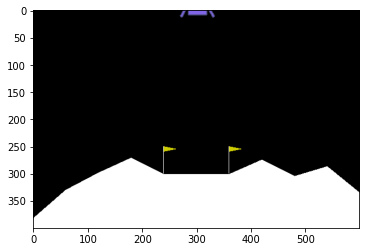

In [12]:
# Box2d Environment
env = gym.make('LunarLanderContinuous-v2')
env.reset()
plt.imshow(env.render('rgb_array'))


In [13]:
state_size = env.observation_space
print("state size is:", state_size)
a = env.action_space
print("action size=",a) 
state = env.reset()
print(state)   

state size is: Box(-inf, inf, (8,), float32)
action size= Box(-1.0, 1.0, (2,), float32)
[ 0.0070425   1.4146249   0.7133082   0.16463538 -0.00815367 -0.161575
  0.          0.        ]


# Action Space
            #is two floats [main engine, left-right engines].
            # Main engine: -1..0 off, 0..+1 throttle from 50% to 100% power. Engine can't work with less than 50% power.
            # Left-right:  -1.0..-0.5 fire left engine, +0.5..+1.0 fire right engine, -0.5..0.5 off
            self.action_space = spaces.Box(-1, +1, (2,), dtype=np.float32)

In [14]:
DF = 0.9 #discount_factor
EPS_START = 0.9
EPS_END = 0.05
EPS_DECAY = 200
max_iterations = 3000
steps_done = 0
TARGET_UPDATE = 10
BATCH_SIZE = 50
GAMMA = 0.999
# torch.autograd.set_detect_anomaly(True)
#mytestmodel.zero_grad()


In [15]:
policy_net =  model(layers).to(device)
target_net =  model(layers).to(device)
target_net.load_state_dict(policy_net.state_dict())
target_net.eval()


model(
  (features): Sequential(
    (0): Linear(in_features=8, out_features=16, bias=True)
    (1): ReLU(inplace=True)
    (2): Linear(in_features=16, out_features=16, bias=True)
    (3): ReLU(inplace=True)
    (4): Linear(in_features=16, out_features=9, bias=True)
    (5): ReLU(inplace=True)
  )
)

In [16]:
optimizer = optim.SGD(policy_net.parameters(), lr=0.3 )#5e-6 RMSprop
dtype = torch.float
losses = []
all_rewards = []


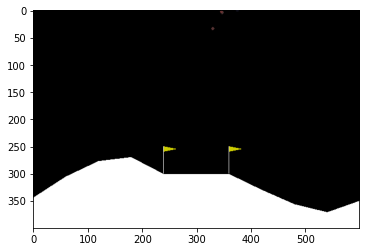

11 action is: [[0, 0], 'Main off, Left Right off'] reward:  -0.8239030345516767 full: tensor(-0.8239) state_value: tensor([0., 0., 0., 0., 0., 0., 0., 0., 0.], grad_fn=<ReluBackward1>) max opt tensor(0., grad_fn=<GatherBackward>)
tensor([0])
state is: [ 0.18241644  1.5124488   0.84112346  0.07383822 -0.14849696 -0.17196883
  0.          0.        ]
12 action is: [[1, 0], 'Main strong, Left Right off'] reward:  -1.0568618411405963 full: tensor(-1.0569) state_value: tensor([0., 0., 0., 0., 0., 0., 0., 0., 0.], grad_fn=<ReluBackward1>) max opt tensor(0., grad_fn=<GatherBackward>)
tensor([6])
state is: [ 0.19917555  1.5156429   0.8561648   0.06844845 -0.16595566 -0.16816236
  0.          0.        ]
13 action is: [[0, 0], 'Main off, Left Right off'] reward:  -2.576167566459117 full: tensor(-2.5762) state_value: tensor([0., 0., 0., 0., 0., 0., 0., 0., 0.], grad_fn=<ReluBackward1>) max opt tensor(0., grad_fn=<GatherBackward>)
tensor([0])
state is: [ 0.21640234  1.5189981   0.8710003   0.0738

In [ ]:
losses = []
all_rewards = []
memory = ReplayMemory(10000)
for a in range(1000):
    print("Episode: ",a,"\n","-"*50)
    env = gym.make('LunarLanderContinuous-v2')
    env.reset()
    env = wrap_env(env)
    done = False
    iter = 0
#     print(done)
    observation = state = env.reset()

    action = 1
    TotalReward = 0
    TotalLoss=0
    df = DF

    while not done and iter < max_iterations :
      iter +=1
      
    #   action = env.action_space.sample()
      if  True:

          sample = random.random()
          eps_threshold = EPS_END + (EPS_START - EPS_END) * math.exp(-1. * steps_done / EPS_DECAY)
          steps_done += 1
          state_values = policy_net.forward(torch.from_numpy(observation))
          if sample > eps_threshold:
                # t.max(1) will return largest column value of each row.
                # second column on max result is index of where max element was
                # found, so we pick action with the larger expected reward.
              real_action = state_values.argmax()

          else:
#               print("random sample")
              real_action = torch.tensor(random.randrange(actions.get_action_count()), device=device, dtype=torch.long)


          action = actions.get_action(real_action.item())
          observation, reward, done, _ = env.step(action)
          with torch.no_grad():
              next_values = target_net.forward(torch.from_numpy(observation))
          if done and True:
              new_reward = next_values.max()+0.1
          else:
            observation, new_reward, done, _ = env.step(action)
    #       state_values[torch.isnan(state_values)] = 0
    #       next_values[torch.isnan(next_values)] = 0
          next_state = observation
          next_val = next_values.max() if next_values.max()!=0 and next_values.max() is not None else -0.1

          label = torch.tensor(reward + (df* new_reward), dtype=torch.float)
          df *=df

          print(iter,"action is:",actions.get_full_action(real_action.item()) ,
                 "reward: ",reward,"full:",label,
                "state_value:",state_values,
                "max opt",state_values.gather(-1,real_action))
          memory.push(state, action, next_state, reward)
          # continue
          print(real_action.unsqueeze(0))
          loss = F.smooth_l1_loss(state_values.gather(-1,real_action),label ) # Huber .unsqueeze(0)
          optimizer.zero_grad()
#           if loss != None:
          loss.backward()
          optimizer.step()
      else:
          transitions = memory.sample(BATCH_SIZE)
          batch = Transition(*zip(*transitions))
          non_final_mask = torch.tensor(tuple(map(lambda s: s is not None, batch.next_state)), device=device, dtype=torch.bool)
          print(f"iter {iter}")
          state_batch = batch.state
          action_batch = batch.action
          reward_batch = batch.reward
          non_final_next_states = torch.tensor([s for s in batch.next_state if s is not None])
          state_values =[]
          with torch.no_grad():
              for i in range(len(state_batch)):
                  our_s = policy_net.forward(torch.from_numpy(state_batch[i])).tolist()
                  state_values.append(our_s)
          state_values = torch.as_tensor(state_values)
          motor_controls = state_values.clone().detach().numpy()
    #       state_values[torch.isnan(state_values)] = 0
    #       next_values[torch.isnan(next_values)] = 0
          next_val = next_values.max() if next_values.max()!=0 and next_values.max() is not None else -0.1
          # state_values = torch.cat(state_values)
          # observation, reward, done, _ = env.step(action_batch[0])
          # state_values = policy_net.forward(torch.from_numpy(observation))
          # print("action is:",actions.get_full_action(state_values.argmax().item())[0] ,"reward: ",reward)
          # next_values = target_net.forward(torch.from_numpy(observation))
          real_action = []
          for i in range(len(state_values)):
             real_action.append(actions.get_full_action(state_values[i].argmax().item())[0])
          real_action = torch.as_tensor(real_action)
          next_state_values = torch.zeros(BATCH_SIZE, device=device).float()
          next_state_values[non_final_mask] = target_net(non_final_next_states).max(1)[0].detach()
          expected_state_action_values = (next_state_values * GAMMA) + torch.tensor(reward_batch)
          expected_state_action_values = expected_state_action_values.float()
          print(f"hedva { expected_state_action_values.unsqueeze(1)}")
          # print(f"yosi  {state_values.gather(-1,real_action)}")
          loss = F.smooth_l1_loss(state_values, expected_state_action_values.unsqueeze(1).double()).float()
          TotalLoss += loss.data.item()
          TotalReward+= sum(reward_batch)
          # Optimize the model
          optimizer.zero_grad()
          print(f"loss {loss}")
          print(f"loss.data {loss.data}")
          loss.requres_grad = True
          loss.backward()
          for param in policy_net.parameters():
              param.grad.data.clamp_(-1, 1)
          optimizer.step()
          # if done and True:
          #     new_reward = next_values.max()+0.1
          # else:
          #     observation, new_reward, done, _ = env.step(action)
          # label = torch.tensor(reward + (df* new_reward), dtype=torch.float)
      # loss = F.smooth_l1_loss(state_values[real_action],label ) # Huber .unsqueeze(0)

          print (loss.data)
      TotalLoss += loss.data.item()
        



      TotalReward+= reward
      print("state is:", observation)

      #if you want to see results on real-time 'open' the following 4 lines
      if iter % TARGET_UPDATE/2 == 0:
          screen = env.render(mode='rgb_array')
          plt.imshow(screen)
          ipythondisplay.clear_output(wait=True)
          ipythondisplay.display(plt.gcf())


      if iter % TARGET_UPDATE == 0:
            target_net.load_state_dict(policy_net.state_dict())
            
    print(TotalReward,iter,done)
    all_rewards.append(TotalReward)
    losses.append(TotalLoss/iter)
    print("-"*50)
    if  a % TARGET_UPDATE*5 == 0:
        ipythondisplay.clear_output(wait=True)
        pickle.dump(policy_net, open(f"model.pkl", "wb"))
        plot(a, all_rewards, losses)
print(f"all {all_rewards}")
print(f"len {len(all_rewards)}")
avg = sum(all_rewards) / len(all_rewards)
print(f"avg = {avg}")
    

In [ ]:
env.close()
show_video()

In [ ]:
print(iter)

In [ ]:
#Draw random samples from a normal (Gaussian) distribution.
mu, sigma = 0, 0.05 # mean and standard deviation
s = np.random.normal(mu, sigma, 1)
print(s)